# Linear Regression

In this assignment, we will first work with using linear regression to solve overdetermined systems. Then, we will apply linear regression to system identification to solve for control parameters.

Run the code block below to import necessary libraries.

In [1]:
!pip install numpy
!pip install matplotlib

import numpy as np
from matplotlib import pyplot as plt
from helper import Model

The system cannot find the path specified.
The system cannot find the path specified.


# Part 1: Model Definition

In this assignment, we will run through a basic example of the `Model` API. Feel free to skip this section if you are already familiar with the content.

## The Model Class

For this set of assignments, you will implement subclasses of a `Model` class. A `Model` object is responsible for both maintaining its state and advancing its internal dynamics. A `Model` object has the following properties:
1. `Model.obs_dim` - the dimensionality of the state space
2. `Model.act_dim` - the expected dimensionality of the `Model`'s  input.
3. `Model._state` - the current state of our model. This can be accessed using the `Model.state()` method. 

All `Model`s are expected to have observation and action dimension specified on instantiation. See the code below for an example.

Furthermore, all `Model`s must implement the following:

1. `Model.forward()` - takes in an `np.array` of expected shape `Model.obs_dim`. The model then returns a tuple of `(state_0, state_1)`, where `state_0` represents the initial state of the model, and `state_1` represents the state of the model after advancing by 1 timestep.

In [2]:
from helper import SampleModel

sample_act_dim = 1
sample_obs_dim = 1

# defining a model by specifying action and observation dimensions
model = SampleModel(sample_act_dim, sample_obs_dim)

In [3]:
print("The model's current state: {}".format(model.state()))

The model's current state: [0.5488135]


In [4]:
# We can advance the state manually using the forward method:
state_0, state_1 = model.forward(np.random.normal())

print("The model's previous state: {}".format(state_0))
print("The model's new state: {}".format(state_1))

# Querying the model's state shows that it has updated:
print("The model's internal state: {}".format(model.state()))

The model's previous state: [0.5488135]
The model's new state: [3.19935423]
The model's internal state: [3.19935423]


In [5]:
# Note that if a state is specified, the internal state is not updated.
sample_state = np.random.random(sample_obs_dim)
state_0, state_1 = model.forward(np.random.normal(sample_act_dim), state=sample_state)

print("Sample state: {}".format(sample_state))
print("The model's previous state: {}".format(state_0))
print("The model's new state: {}".format(state_1))

# Querying the model's state shows that it has NOT updated:
print("The model's internal state: {}".format(model.state()))

Sample state: [0.54488318]
The model's previous state: [0.54488318]
The model's new state: [0.65737167]
The model's internal state: [3.19935423]


## Part 2: Linear Regression

In this section, we will explore using linear regression to solve overdetermined systems of equations. 

### Linear Regression
Linear Regression is a technique used to solve the least squares problem; in the least squares problem, we aim to minimize a ***cost function*** $\mathcal{L}(y,\hat{y}) = \lVert \hat{y}-y \rVert_2^2$.

Let $\hat{y} = Xw$, where $X$ is a ***design matrix*** of dimensions $R^{n \times d}$, where $n$ is the number of sample points and $d$ is the dimension of each input. 

By setting the gradient with respect to w of the above function to 0, we obtain that the optimizer $w* = (X^TX)^{-1}X^Ty$. This solution is flexible and works for any matrices satisifying the setup above, provided they meet some constraints.

### Question 1: Complex 1D model with no inputs
In this question, we will aim to solve a complex 1D model. Run the following code block to initialize the model.

***NOTE***: this model is independent of inputs. For simplicity, you can ignore inputting actions for this model (they will not affect it in any way).

In [6]:
from helper import Complex1DModel

act_dim = 1
obs_dim = 1

model = Complex1DModel(act_dim, obs_dim)

In order to approximate the system, we need to collect samples of transitions between ($x, y$).
1. Use the `Model`s `forward()` method to collect transitions between states. You can choose to either run one state sequentially, or use the optional `state0` argument to specify an initial state $x$. (Hint: we want to explore many different regions of operation. Is one option better suited to this?)
2. Store the results in an `np.array`; be sure to set up the design matrix $X$ and the outputs $y$ accordingly.
3. Solve the problem using the closed form least square solution. You can implement this manually, or use a popular computing package (i.e. `numpy` or `scipy`)

To be safe, it should be enough to collect 30 data points. However, collecting more will likely increase the fidelity of your models.

In [7]:
# solution:
def linear_regression_1d(model):
    batches = 1000
    X = []
    Y = []
    w = None
    
    for i in range(batches):
        state = np.random.random(obs_dim)
        x, y = model.forward(state=state)
        X += [x]
        Y += [y]

    X = np.array(X)
    Y = np.array(Y)

    w = np.linalg.inv(X.T @ X) @ X.T @ Y
    
    return w

In [8]:
w = linear_regression_1d(model)
print("optimizer: {}".format(w))

optimizer: [[31.62488781]]


Now, lets evaluate the solution that we created. Run the following code block to visualize the results.

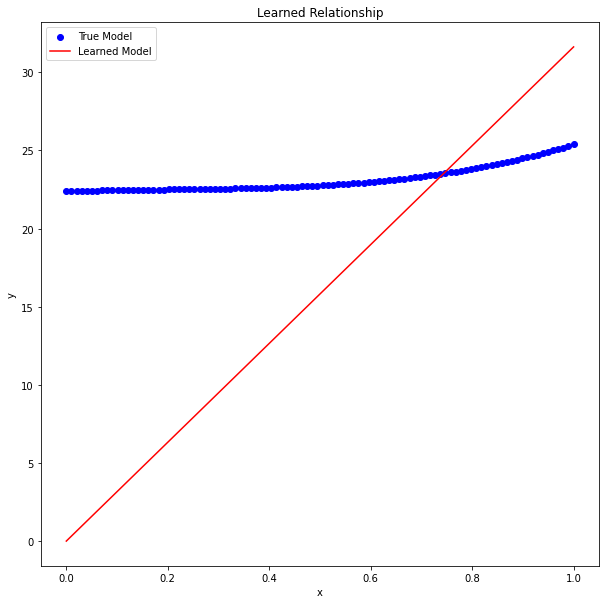

MSE loss: 12585.532834271045


In [9]:
from helper import MSE_loss

X = np.linspace(0, 1, 100)[:, np.newaxis]
y_hat = X @ w
_, Y = model.forward(state=X)

plt.figure(figsize=(10, 10))
true_model = plt.scatter(X, Y, c='blue', label='True Model')
learned_model, = plt.plot(X, y_hat, c='red', label='Learned Model')

plt.legend(handles=[true_model ,learned_model])

plt.xlabel("x")
plt.ylabel("y")
plt.title("Learned Relationship")
    
plt.show()

print("MSE loss: {}".format(MSE_loss(Y, y_hat).item()))

In [10]:
# solution:
def linear_regression_features(model):
    batches = 100000
    X = []
    Y = []
    w = None
    
    for i in range(batches):
        state = np.random.random(obs_dim)
        x, y = model.forward(state=state)
        X += [[x ** 3, x ** 2, x, x ** 0]]
        Y += [y]

    X = np.squeeze(np.array(X))
    Y = np.array(Y)
    
    w = np.linalg.inv(X.T @ X) 
    w = w @ X.T 
    w = w @ Y
    
    return w

In [11]:
w = linear_regression_features(model)
print("optimizer: {}".format(w))

optimizer: [[ 5.15049577]
 [-3.2677099 ]
 [ 1.13994146]
 [19.98768112]]


Now, lets evaluate the solution that we created. Run the following code block to visualize the results.

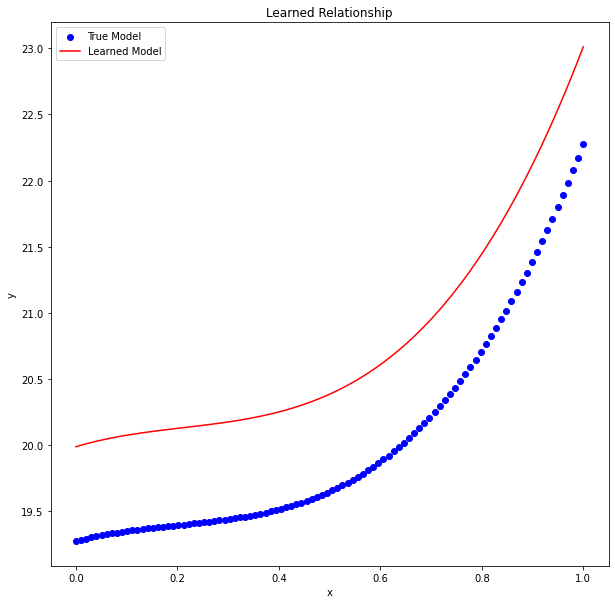

MSE loss: 120.222533299628


In [12]:
from helper import MSE_loss

X = np.linspace(0, 1, 100)
X_features = np.stack([X ** 3, X ** 2, X, np.ones(X.shape)]).T

y_hat = X_features @ w
_, Y = model.forward(state=X)

plt.figure(figsize=(10, 10))
true_model = plt.scatter(X, Y, c='blue', label='True Model')
learned_model, = plt.plot(X, y_hat, c='red', label='Learned Model')

plt.legend(handles=[true_model ,learned_model])

plt.xlabel("x")
plt.ylabel("y")
plt.title("Learned Relationship")
    
plt.show()

print("MSE loss: {}".format(MSE_loss(Y, y_hat).item()))

## Part 3: Linear Regression for System Identification

In [35]:
from helper import Motion2DModel

act_dim = 2
obs_dim = 4
initial_state = np.zeros(obs_dim)

model = Motion2DModel(act_dim, obs_dim, initial_state=initial_state)

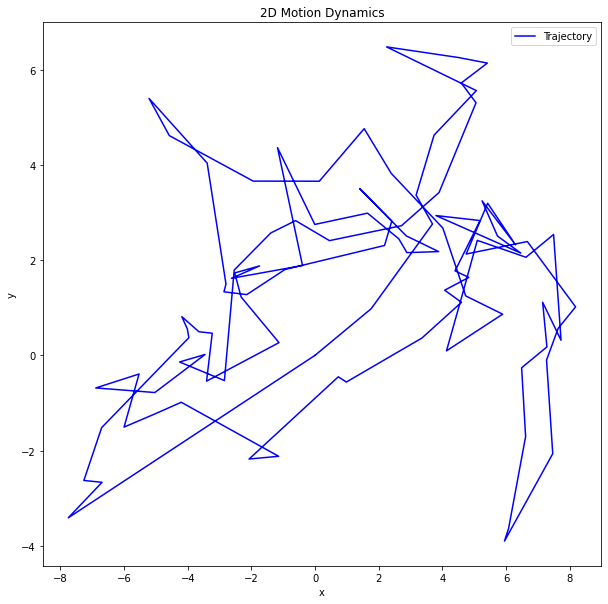

In [36]:
pos = np.zeros((1000, model.obs_dim))
act = np.vstack([np.cos(np.linspace(-np.pi, np.pi, 100)),
                 np.sin(np.linspace(-np.pi, np.pi, 100))]).T

for (i, u) in enumerate(act):
    pos[i, :], _ = model.forward(input=u)
    
plt.figure(figsize=(10, 10))
traj, = plt.plot(pos[:,0], pos[:,2], c='blue', label='Trajectory')
plt.legend(handles=[traj])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Motion Dynamics")
plt.show()

In [33]:
# solution:
def linear_regression_motion(model):
    batches = 1000
    X = []
    Y = []
    A = None
    b = None
    
    for i in range(batches):
        state = np.random.uniform(-1000, 1000, model.obs_dim)
        act = np.random.uniform(-5, 5, model.act_dim)
        x, y = model.forward(state=state)
        x = np.hstack((x, act))
        X += [[x]]
        Y += [y]
        
    X = np.squeeze(np.array(X))
    Y = np.array(Y)
        
    w = np.linalg.inv(X.T @ X) 
    w = w @ X.T 
    w = w @ Y
    w = w.T
    
    A = w[:, :4]
    b = w[:, 4:]
    
    return A, b

In [34]:
A, b = linear_regression_motion(model)
print("A:\n{}\nB:\n{}".format(A, b))

A:
[[ 1.00002410e+00  3.70069135e-01 -5.27857950e-05 -1.49009741e-05]
 [-8.41437332e-05  6.30009551e-01 -9.61385672e-06  3.24850879e-06]
 [ 5.66432529e-05  2.66476828e-05  1.00000870e+00  3.70076384e-01]
 [-3.08627960e-05  2.23597111e-05  1.88955544e-05  6.29935137e-01]]
B:
[[ 0.00153335  0.01615252]
 [ 0.00120799 -0.00802564]
 [ 0.00260899 -0.01056361]
 [-0.01685757 -0.01729792]]


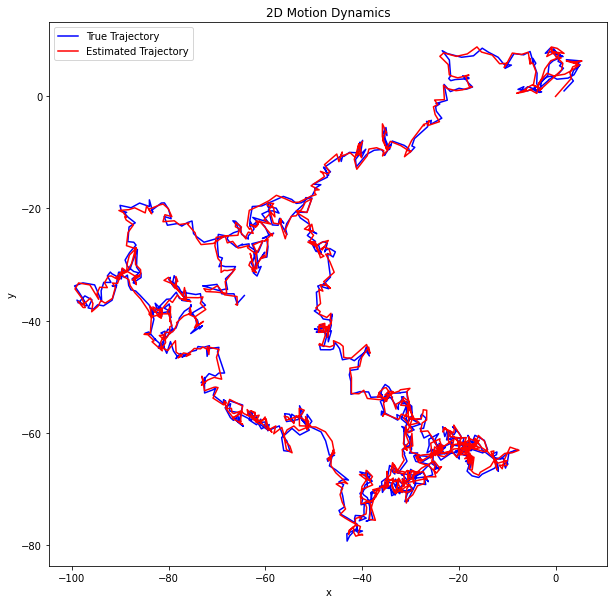

MSE loss: 483.6517409379069


In [30]:
initial_state = np.zeros(obs_dim)

model = Motion2DModel(act_dim, obs_dim, initial_state=initial_state)

true_pos = np.zeros((1000, model.obs_dim))
est_pos = np.zeros((1000, model.obs_dim))

act = np.vstack([np.cos(np.linspace(-np.pi, np.pi, 1000)),
                 np.sin(np.linspace(-np.pi, np.pi, 1000))]).T

for (i, u) in enumerate(act):
    est_pos[i, :], true_pos[i, :] = model.forward(input=u)
    est_pos[i, :] = A @ est_pos[i, :] + b @ u
    
plt.figure(figsize=(10, 10))
true_traj, = plt.plot(true_pos[:,0], true_pos[:,2], c='blue', label='True Trajectory')
est_traj, = plt.plot(est_pos[:,0], est_pos[:,2], c='red', label='Estimated Trajectory')
plt.legend(handles=[true_traj, est_traj])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Motion Dynamics")
plt.show()
print("MSE loss: {}".format(MSE_loss(true_pos[:, [0, 2]], est_pos[:, [0, 2]]).item()))